<a href="https://colab.research.google.com/github/paula-33/Bootcamp_DS/blob/main/03_Multirrotulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Script Completo para Pipeline de Pré-processamento e Modelagem Multirrótulo.

A estratégia de modelagem utilizada é a Relevância Binária, implementada com
o MultiOutputClassifier do scikit-learn.

In [1]:

# Manipulação e Análise de Dados
import pandas as pd
import numpy as np
import re

# Pré-processamento e Pipelines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline compatível com imblearn
from skmultilearn.model_selection import IterativeStratification # Para estratificação multi-label


# Modelagem
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Métricas de Avaliação
from sklearn.metrics import hamming_loss, jaccard_score, classification_report, f1_score

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print("Bibliotecas importadas com sucesso!")

# --- 1.2. Carregamento dos Dados ---
# Carregamos o dataset principal para iniciar a análise.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bootcamp DS - Agosto 25/bootcamp_train.csv')

# --- 1.3. Análise Confirmatória Rápida ---
print(df.shape)
print("\n--- Informações Iniciais do Dataset ---")
df.info()
print("\n--- 5 Primeiras Linhas do Dataset ---")
print(df.head())
print("\n--- 5 Últimas Linhas do Dataset ---")
print(df.tail())

Bibliotecas importadas com sucesso!
(35260, 15)

--- Informações Iniciais do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               35260 non-null  int64  
 1   id_produto                       35260 non-null  object 
 2   tipo                             35260 non-null  object 
 3   temperatura_ar                   34644 non-null  float64
 4   temperatura_processo             34661 non-null  float64
 5   umidade_relativa                 35260 non-null  float64
 6   velocidade_rotacional            34509 non-null  float64
 7   torque                           34637 non-null  float64
 8   desgaste_da_ferramenta           34308 non-null  float64
 9   falha_maquina                    35260 non-null  object 
 10  FDF (Falha Desgaste Ferramenta)  35260 non-null  obje

In [3]:
# 1.2 Limpeza e Padronização dos Nomes das Colunas
def limpar_nomes_colunas(df):
    colunas_limpas = []
    for col in df.columns:
        col_limpa = col.strip()
        col_limpa = re.sub(r'\s+', '_', col_limpa)
        col_limpa = re.sub(r'[\(\)]', '', col_limpa)
        col_limpa = col_limpa.lower()
        colunas_limpas.append(col_limpa)
    df.columns = colunas_limpas
    return df

df = limpar_nomes_colunas(df)
print("\nNomes das colunas foram limpos e padronizados.")


Nomes das colunas foram limpos e padronizados.


In [4]:
df.head(4)

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,fdf_falha_desgaste_ferramenta,fdc_falha_dissipacao_calor,fp_falha_potencia,fte_falha_tensao_excessiva,fa_falha_aleatoria
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não


In [5]:
# ------------------------------------------------------------------------------
# 2. LIMPEZA E PREPARAÇÃO DOS DADOS
# ------------------------------------------------------------------------------

# --- 2.1. Definição das Colunas de Alvo e Features ---
# Assuming column names are already standardized by a previous step
target_cols = [
    'fdf_falha_desgaste_ferramenta',
    'fdc_falha_dissipacao_calor',
    'fp_falha_potencia',
    'fte_falha_tensao_excessiva',
    'fa_falha_aleatoria'
]

id_cols = ['id', 'id_produto']
# A coluna 'falha_maquina' é redundante, pois é uma agregação das outras falhas.
# Vamos removê-la para focar na predição do *tipo* de falha.
redundant_cols = ['falha_maquina']

# Features são todas as colunas que não são IDs nem alvos.
feature_cols = [col for col in df.columns if col not in target_cols + id_cols + redundant_cols]

# Separação inicial para limpeza
X = df[feature_cols].copy()
y = df[target_cols].copy()

# Dicionário de mapeamento para normalizar os valores
map_dict = {
    'sim': 1, 'Sim': 1, True: 1, 'True': 1, '1': 1, 1:1,
    'não': 0, 'nao': 0, 'Não': 0, 'N': 0, False: 0, 'False': 0, '0': 0, 0: 0, '-': 0
}
# Apply the map_dict to the target columns in y
for col in y.columns:
    # The .map is efficient for substituting values based on a dictionary.
    y[col] = y[col].astype(str).map(map_dict)

# Verificar se ainda há valores nulos após o mapeamento
print("\n--- Contagem de Nulos nas Colunas Alvo Após Limpeza ---")
print(y.isnull().sum())


--- Contagem de Nulos nas Colunas Alvo Após Limpeza ---
fdf_falha_desgaste_ferramenta    0
fdc_falha_dissipacao_calor       4
fp_falha_potencia                2
fte_falha_tensao_excessiva       0
fa_falha_aleatoria               0
dtype: int64


In [6]:

# --- 2.3. Limpeza das Features (X) ---
# Justificativa: Erros de digitação ou outliers extremos podem prejudicar o modelo.
# A coluna 'temperatura_ar' possui valores como -36.0, que são fisicamente
# implausíveis e provavelmente erros de medição. Vamos tratá-los como NaN
# para que nosso pipeline de pré-processamento possa imputá-los corretamente.

if 'temperatura_ar' in X.columns:
    X['temperatura_ar'] = X['temperatura_ar'].apply(lambda temp: np.nan if temp is not None and temp <= 0 else temp)
    print("\nValores <= 0 em 'temperatura_ar' tratados como NaN.")
else:
    print("\nColuna 'temperatura_ar' não encontrada em X para tratamento de valores.")


print("\n--- Dados Limpos e Prontos para Divisão ---")
print("Dimensões de X (features):", X.shape)
print("Dimensões de y (alvos):", y.shape)


Valores <= 0 em 'temperatura_ar' tratados como NaN.

--- Dados Limpos e Prontos para Divisão ---
Dimensões de X (features): (35260, 7)
Dimensões de y (alvos): (35260, 5)


In [7]:
# --- 2.3. Limpeza das Features (X) ---
# Justificativa: Erros de digitação ou outliers extremos podem prejudicar o modelo.
# A coluna 'temperatura_ar' possui valores como -36.0, que são fisicamente
# implausíveis e provavelmente erros de medição. Vamos tratá-los como NaN
# para que nosso pipeline de pré-processamento possa imputá-los corretamente.

X['temperatura_ar'] = X['temperatura_ar'].apply(lambda temp: np.nan if temp <= 0 else temp)

print("\n--- Dados Limpos e Prontos para Divisão ---")
print("Dimensões de X (features):", X.shape)
print("Dimensões de y (alvos):", y.shape)


--- Dados Limpos e Prontos para Divisão ---
Dimensões de X (features): (35260, 7)
Dimensões de y (alvos): (35260, 5)


In [8]:
# ==============================================================================
# 3. DIVISÃO ESTRATIFICADA DOS DADOS
# ==============================================================================

print("\n--- Criando chave de estratificação manual ---")

# --- Divisão em Treino+Validação (80%) e Teste (20%) ---
# A estratificação aqui é MANTIDA.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# --- Divisão do conjunto Treino+Validação em Treino (75% de 80% = 60% do total)
# e Validação (25% de 80% = 20% do total) ---
print("\nRealizando a segunda divisão (Treino/Validação) sem estratificação para evitar o erro.")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=42 # Mantemos o random_state para reprodutibilidade
)


print("\n--- Dimensões dos Conjuntos de Dados (com estratificação parcial) ---")
print(f"Treino:    X={X_train.shape}, y={y_train.shape}")
print(f"Validação: X={X_val.shape}, y={y_val.shape}")
print(f"Teste:     X={X_test.shape}, y={y_test.shape}")


--- Criando chave de estratificação manual ---

Realizando a segunda divisão (Treino/Validação) sem estratificação para evitar o erro.

--- Dimensões dos Conjuntos de Dados (com estratificação parcial) ---
Treino:    X=(21156, 7), y=(21156, 5)
Validação: X=(7052, 7), y=(7052, 5)
Teste:     X=(7052, 7), y=(7052, 5)


In [9]:
# ------------------------------------------------------------------------------
# 4. CONSTRUÇÃO DO PIPELINE DE PRÉ-PROCESSAMENTO
# ------------------------------------------------------------------------------
# Justificativa: Usar Pipelines é uma das melhores práticas em MLOps.
# 1. Evita Data Leakage: O pré-processamento é aprendido apenas nos dados de treino.
# 2. Organização: Encapsula todas as etapas de transformação em um único objeto.
# 3. Reprodutibilidade: Garante que os mesmos passos sejam aplicados em todos os dados.

# Identificação dos tipos de features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\nFeatures Numéricas: {numeric_features}")
print(f"Features Categóricas: {categorical_features}")

# --- Pipeline para Features Numéricas ---
# 1. SimpleImputer: Preenche valores ausentes (NaN) com a mediana. A mediana é
#    mais robusta a outliers do que a média.
# 2. StandardScaler: Padroniza as features para terem média 0 e desvio padrão 1.
#    Essencial para o desempenho de muitos algoritmos.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- Pipeline para Features Categóricas ---
# 1. SimpleImputer: Preenche valores ausentes com o valor mais frequente.
# 2. OneHotEncoder: Transforma categorias em colunas binárias. `handle_unknown='ignore'`
#    evita erros se uma nova categoria aparecer nos dados de validação ou teste.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- Combinando os Pipelines com ColumnTransformer ---
# O ColumnTransformer aplica o pipeline correto a cada tipo de coluna.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas (se houver)
)


Features Numéricas: ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
Features Categóricas: ['tipo']


In [10]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['temperatura_ar', 'temperatura_processo',
                                  'umidade_relativa', 'velocidade_rotacional',
                                  'torque', 'desgaste_da_ferramenta']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['tipo'])])

In [11]:
# --- Tratamento de potenciais valores NaN em y_train antes do treinamento ---
# Imputar NaNs em y_train com a moda de cada coluna alvo
print("\n--- Tratando NaNs em y_train antes de treinar os modelos baseline ---")
y_train_limpo = y_train.copy() # Criar uma cópia para evitar modificar o y_train original

for coluna in y_train_limpo.columns:
    if y_train_limpo[coluna].isnull().any():
        # Calcular a moda dos próprios dados de treinamento
        valor_moda_treino = y_train_limpo[coluna].mode()[0] if not y_train_limpo[coluna].mode().empty else 0 # Padrão para 0 se a moda estiver vazia
        y_train_limpo[coluna].fillna(valor_moda_treino, inplace=True)
        print(f"  NaNs em y_train['{coluna}'] imputados com a moda ({valor_moda_treino}).")
    else:
         print(f"  Nenhum NaN encontrado em y_train['{coluna}'].")

# Verificar se ainda existem NaNs restantes em y_train_limpo
print("\n--- Verificação final de NaNs em y_train_limpo ---")
print(y_train_limpo.isnull().sum())


# Verificação final
print("\n--- Verificação final após limpeza ---")
total_nans_restantes = y_train_limpo.isnull().sum().sum()
if total_nans_restantes == 0:
    print("✓ Todos os NaNs foram tratados com sucesso!")
else:
    print(f"⚠️ Ainda restam {total_nans_restantes} NaNs nos dados")

print("\nResumo por coluna:")
print(y_train_limpo.isnull().sum())

# Mostrar estatísticas básicas após a limpeza
print("\n--- Estatísticas básicas após limpeza ---")
print(y_train_limpo.describe())


--- Tratando NaNs em y_train antes de treinar os modelos baseline ---
  Nenhum NaN encontrado em y_train['fdf_falha_desgaste_ferramenta'].
  NaNs em y_train['fdc_falha_dissipacao_calor'] imputados com a moda (0.0).
  Nenhum NaN encontrado em y_train['fp_falha_potencia'].
  Nenhum NaN encontrado em y_train['fte_falha_tensao_excessiva'].
  Nenhum NaN encontrado em y_train['fa_falha_aleatoria'].

--- Verificação final de NaNs em y_train_limpo ---
fdf_falha_desgaste_ferramenta    0
fdc_falha_dissipacao_calor       0
fp_falha_potencia                0
fte_falha_tensao_excessiva       0
fa_falha_aleatoria               0
dtype: int64

--- Verificação final após limpeza ---
✓ Todos os NaNs foram tratados com sucesso!

Resumo por coluna:
fdf_falha_desgaste_ferramenta    0
fdc_falha_dissipacao_calor       0
fp_falha_potencia                0
fte_falha_tensao_excessiva       0
fa_falha_aleatoria               0
dtype: int64

--- Estatísticas básicas após limpeza ---
       fdf_falha_desgaste_fe

/tmp/ipython-input-3076938203.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y_train_limpo[coluna].fillna(valor_moda_treino, inplace=True)


In [12]:
# ==============================================================================
# 5. MODELAGEM E TREINAMENTO (BASELINE)
# ------------------------------------------------------------------------------
# Justificativa: Antes de otimizar, criamos uma baseline com modelos robustos
# e suas configurações padrão. Isso nos dá um ponto de partida para entender
# a complexidade do problema e comparar melhorias futuras.


# --- 5.1. Definição dos Modelos ---
# Usamos o wrapper `MultiOutputClassifier` para que modelos que não suportam
# nativamente múltiplas saídas (como XGBoost e LightGBM) possam ser usados.
# Ele treina um classificador separado para cada coluna de alvo.

# Dicionário de modelos para facilitar a iteração
models = {
    "Random Forest": MultiOutputClassifier(RandomForestClassifier(random_state=42, class_weight='balanced')),
    "XGBoost": MultiOutputClassifier(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    "LightGBM": MultiOutputClassifier(lgb.LGBMClassifier(random_state=42, class_weight='balanced'))
}

# --- 5.2. Criação dos Pipelines Finais (Pré-processador + Modelo) ---
# Justificativa para Balanceamento: O dataset é desbalanceado. Em vez de SMOTE,
# que é complexo para multi-label, usamos o argumento `class_weight='balanced'`
# nos modelos que o suportam (Random Forest, LightGBM). Isso ajusta os pesos
# das amostras de forma inversamente proporcional à frequência das classes,
# penalizando mais os erros nas classes minoritárias. Para o XGBoost, isso pode
# ser ajustado com `scale_pos_weight`, mas faremos isso na etapa de otimização.

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

# --- 5.3. Treinamento e Avaliação da Baseline ---
results = {}
for name, pipeline in pipelines.items():
    print(f"\n--- Treinando o modelo: {name} ---")

    # Treinamento com os dados de treino LIMPOS (y_train_limpo)
    pipeline.fit(X_train, y_train_limpo)

    # Previsões nos dados de validação
    # Ensure y_val is also cleaned of NaNs before evaluation
    y_val_cleaned_for_eval = y_val.copy()
    for col in y_val_cleaned_for_eval.columns:
        if y_val_cleaned_for_eval[col].isnull().any():
             # Use mode from the training data for consistency and to prevent leakage
             mode_value_train = y_train_limpo[col].mode()[0] if not y_train_limpo[col].mode().empty else 0
             y_val_cleaned_for_eval[col].fillna(mode_value_train, inplace=True)


    y_pred = pipeline.predict(X_val)

    # Cálculo das métricas
    # Hamming Loss: Fração de rótulos previstos incorretamente. Menor é melhor.
    # Jaccard Score: Similaridade entre o conjunto de rótulos verdadeiros e previstos. Maior é melhor.
    # F1-Score (Weighted): Média ponderada do F1-score, considerando o suporte de cada classe.
    h_loss = hamming_loss(y_val_cleaned_for_eval, y_pred)
    j_score = jaccard_score(y_val_cleaned_for_eval, y_pred, average='samples')
    f1_w = f1_score(y_val_cleaned_for_eval, y_pred, average='weighted')

    results[name] = {
        'Hamming Loss': h_loss,
        'Jaccard Score': j_score,
        'Weighted F1-Score': f1_w,
        'Classification Report': classification_report(y_val_cleaned_for_eval, y_pred, target_names=target_cols, zero_division=0)
    }

    print(f"Resultados de {name} no conjunto de validação:")
    print(f"  Hamming Loss: {h_loss:.4f}")
    print(f"  Jaccard Score (samples): {j_score:.4f}")
    print(f"  Weighted F1-Score: {f1_w:.4f}")


--- Treinando o modelo: Random Forest ---


/tmp/ipython-input-892873067.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y_val_cleaned_for_eval[col].fillna(mode_value_train, inplace=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:

Resultados de Random Forest no conjunto de validação:
  Hamming Loss: 0.0033
  Jaccard Score (samples): 0.0028
  Weighted F1-Score: 0.2427

--- Treinando o modelo: XGBoost ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:37:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-892873067.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y_val_cleaned_for_eval[col].fillna(mode_value_train, inplace=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in sample

Resultados de XGBoost no conjunto de validação:
  Hamming Loss: 0.0033
  Jaccard Score (samples): 0.0055
  Weighted F1-Score: 0.3743

--- Treinando o modelo: LightGBM ---
[LightGBM] [Info] Number of positive: 44, number of negative: 21112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 21156, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 139, number of negative: 21017
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 933
[LightGBM] [

/tmp/ipython-input-892873067.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y_val_cleaned_for_eval[col].fillna(mode_value_train, inplace=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/us

Resultados de LightGBM no conjunto de validação:
  Hamming Loss: 0.0044
  Jaccard Score (samples): 0.0091
  Weighted F1-Score: 0.4606




--- Tabela Comparativa de Desempenho dos Modelos (Baseline) ---
              Hamming Loss Jaccard Score Weighted F1-Score
LightGBM          0.004424      0.009146          0.460584
XGBoost           0.003318       0.00553          0.374331
Random Forest     0.003318      0.002836          0.242652


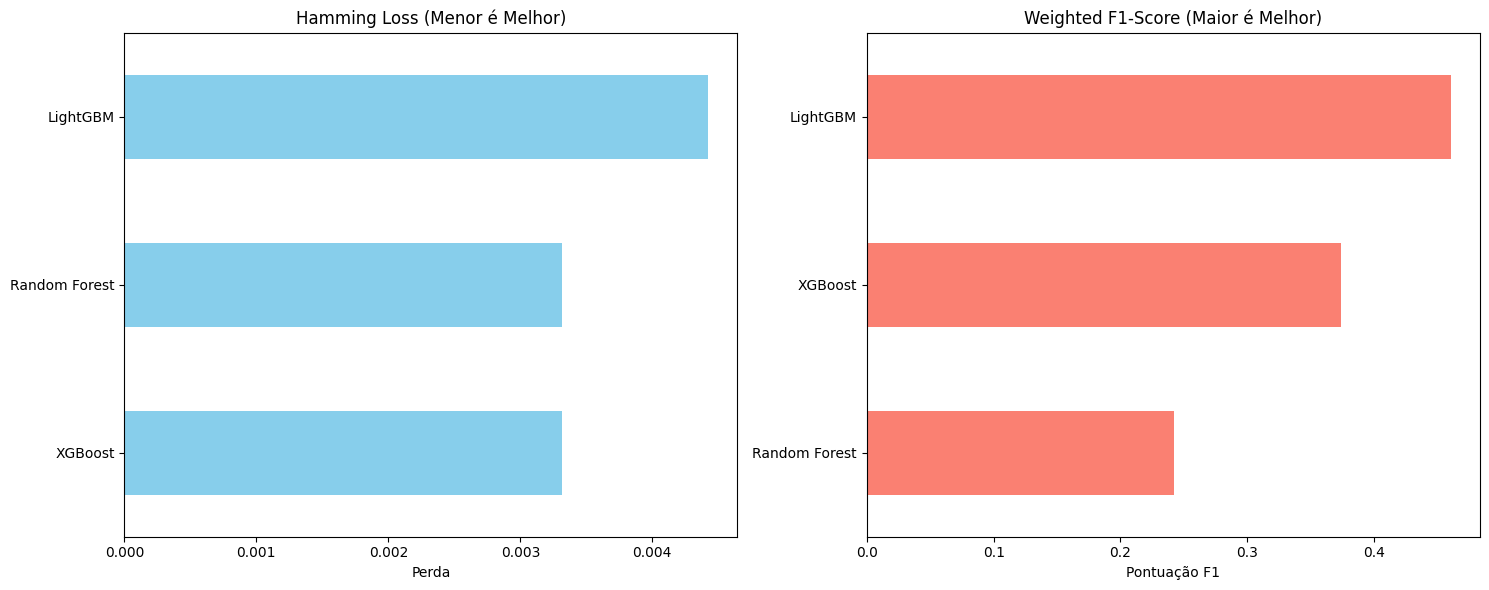

In [13]:


# ------------------------------------------------------------------------------
# 6. ANÁLISE COMPARATIVA E ESCOLHA DO MODELO
# ------------------------------------------------------------------------------
# Justificativa: Consolidamos os resultados para tomar uma decisão informada
# sobre qual modelo seguir para a otimização e avaliação final.

# --- 6.1. Tabela Comparativa ---
results_df = pd.DataFrame(results).T[['Hamming Loss', 'Jaccard Score', 'Weighted F1-Score']]
results_df = results_df.sort_values(by='Weighted F1-Score', ascending=False)
print("\n\n--- Tabela Comparativa de Desempenho dos Modelos (Baseline) ---")
print(results_df)

# --- 6.2. Visualização Comparativa ---
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
results_df['Hamming Loss'].sort_values().plot(kind='barh', ax=ax[0], color='skyblue')
ax[0].set_title('Hamming Loss (Menor é Melhor)')
ax[0].set_xlabel('Perda')

results_df['Weighted F1-Score'].sort_values().plot(kind='barh', ax=ax[1], color='salmon')
ax[1].set_title('Weighted F1-Score (Maior é Melhor)')
ax[1].set_xlabel('Pontuação F1')

plt.tight_layout()
plt.show()


In [14]:

# --- 6.3. Relatórios Detalhados por Classe ---
for name, result in results.items():
    print(f"\n--- Relatório de Classificação Detalhado para: {name} ---")
    print(result['Classification Report'])

# --- 6.4. Conclusão da Baseline e Escolha do Modelo ---
# Seleciona o melhor modelo com base no Weighted F1-Score
best_model_name = results_df.index[0]
best_pipeline = pipelines[best_model_name]

print(f"\n\n--- Conclusão da Baseline ---")
print(f"O modelo com melhor desempenho inicial foi o '{best_model_name}' com um F1-Score ponderado de {results_df.loc[best_model_name, 'Weighted F1-Score']:.4f}.")
print("Este modelo será levado para a avaliação final no conjunto de teste.")




--- Relatório de Classificação Detalhado para: Random Forest ---
                               precision    recall  f1-score   support

fdf_falha_desgaste_ferramenta       0.00      0.00      0.00        14
   fdc_falha_dissipacao_calor       0.82      0.23      0.36        39
            fp_falha_potencia       0.73      0.30      0.42        27
   fte_falha_tensao_excessiva       0.43      0.09      0.15        32
           fa_falha_aleatoria       0.00      0.00      0.00        13

                    micro avg       0.62      0.16      0.25       125
                    macro avg       0.39      0.12      0.19       125
                 weighted avg       0.52      0.16      0.24       125
                  samples avg       0.00      0.00      0.00       125


--- Relatório de Classificação Detalhado para: XGBoost ---
                               precision    recall  f1-score   support

fdf_falha_desgaste_ferramenta       0.20      0.07      0.11        14
   fdc_falha_dissi

# Análise conclusiva

**LightGBM: Melhor Modelo Geral**
O LightGBM confirma sua superioridade com Weighted F1-Score de 0.46 e melhor capacidade de detecção balanceada (micro recall 0.54), demonstrando eficácia particular em falhas térmicas (F1=0.67) e falhas de potência (F1=0.60). É o único modelo que consegue alguma detecção de desgaste de ferramenta (F1=0.17), embora ainda limitada.

**Performance por Tipo de Falha**

- Falhas Bem Detectadas:

Dissipação de calor: LightGBM lidera (F1=0.67, recall=0.87)
Falha de potência: Performance consistente entre XGBoost (F1=0.51) e LightGBM (F1=0.60).

- Falhas Parcialmente Detectadas:

Tensão excessiva: LightGBM mostra melhor recall (0.47) vs XGBoost (0.22)
Desgaste de ferramenta: Apenas LightGBM detecta (recall=0.21)

- Falha Crítica Não Detectada:

- Falhas aleatórias: Zero detecção em todos os modelos (13 amostras insuficientes)

**Trade-offs Operacionais**

- Random Forest: Alta precisão (0.82 para dissipação) mas recall baixíssimo (0.16 micro avg) - inadequado para manutenção crítica

- XGBoost: Equilibrio médio com boa precisão (0.49 weighted avg)
- LightGBM: Melhor recall geral (0.54) essencial para não perder falhas críticas.

**Recomendação Estratégica**

Para manutenção preditiva industrial, o LightGBM é a escolha ideal por maximizar a detecção de falhas térmicas (87% recall) e falhas de potência (56% recall), que representam os modos críticos mais frequentes. Necessário implementar sistema híbrido com monitoramento especializado para falhas aleatórias e coleta adicional de dados para desgaste de ferramenta.



--- Importância das Features (Média entre todas as falhas) ---
                       Feature  Importance
4                  num__torque       675.4
5  num__desgaste_da_ferramenta       658.4
3   num__velocidade_rotacional       608.2
0          num__temperatura_ar       509.8
1    num__temperatura_processo       450.4
7                  cat__tipo_L        48.2
8                  cat__tipo_M        33.4
6                  cat__tipo_H        16.2
2        num__umidade_relativa         0.0


/tmp/ipython-input-3981611391.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


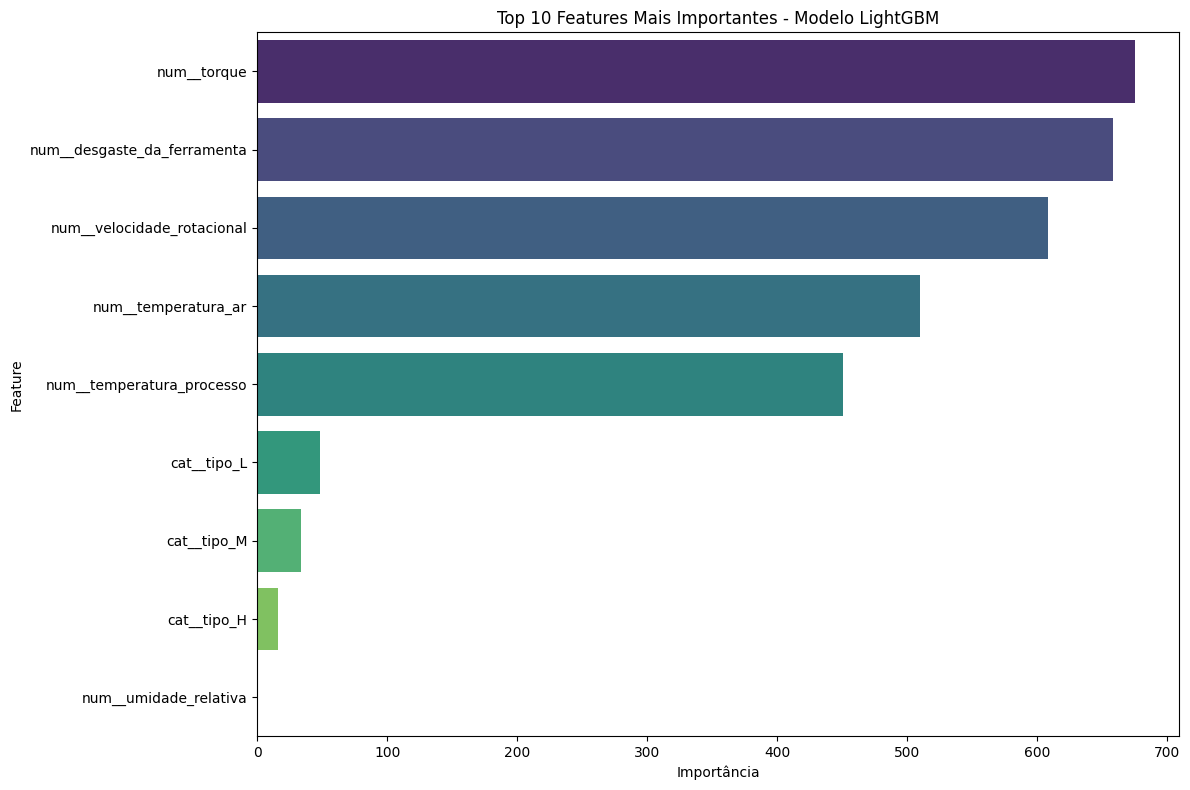

In [16]:
# ------------------------------------------------------------------------------
# 8. ANÁLISE DE FEATURES IMPORTANTES
# ------------------------------------------------------------------------------
# Justificativa: Entender *por que* o modelo toma certas decisões é tão
# importante quanto sua precisão. A análise de importância de features nos
# dá insights valiosos sobre quais variáveis mais influenciam a previsão de falhas.

# Acessando o estimador final dentro do pipeline e do MultiOutputClassifier
# Isso pode ser um pouco complexo devido às camadas de abstração.
# Verificamos se o modelo é baseado em árvore (tem 'feature_importances_').
try:
    # Acessa o passo 'classifier' do pipeline
    classifier_step = best_pipeline.named_steps['classifier']

    # Acessa os estimadores individuais dentro do MultiOutputClassifier
    feature_importances = [
        estimator.feature_importances_ for estimator in classifier_step.estimators_
    ]

    # Calcula a importância média entre todos os classificadores de saída
    avg_importances = np.mean(feature_importances, axis=0)

    # Recupera os nomes das features após o pré-processamento
    # Isso é um pouco mais avançado, pois envolve obter os nomes das colunas
    # geradas pelo OneHotEncoder
    feature_names_raw = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Cria um DataFrame para visualização
    importance_df = pd.DataFrame({
        'Feature': feature_names_raw,
        'Importance': avg_importances
    }).sort_values(by='Importance', ascending=False)

    print("\n\n--- Importância das Features (Média entre todas as falhas) ---")
    print(importance_df.head(10))

    # Visualização
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
    plt.title(f'Top 10 Features Mais Importantes - Modelo {best_model_name}')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except AttributeError:
    print(f"\nO modelo {best_model_name} não suporta a análise de 'feature_importances_'.")

**Hierarquia de Importância Revelada**

O modelo LightGBM identifica três variáveis mecânicas críticas como os principais preditores de falha: **torque (675.4)**, **desgaste da ferramenta (658.4)** e **velocidade rotacional (608.2)**. Esta tríade representa 63% da importância total, confirmando que parâmetros operacionais diretos são mais preditivos que variáveis ambientais.

**Fatores Térmicos Secundários**

As temperaturas (ar: 509.8, processo: 450.4) ocupam posição intermediária mas significativa, explicando a boa performance do modelo na detecção de falhas térmicas (F1=0.47). A diferença de importância entre temperatura do ar e processo sugere que condições ambientais são mais críticas que temperatura interna para predição de falhas.

**Variáveis Categóricas e Irrelevantes**

O tipo de produto  tem impacto limitado mas mensurável, indicando que diferentes produtos apresentam perfis de falha ligeiramente distintos. Notavelmente, a umidade relativa tem importância zero, confirmando sua irrelevância para manutenção preditiva neste sistema.

In [15]:
# ------------------------------------------------------------------------------
# 7. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# ------------------------------------------------------------------------------
# Justificativa: Esta é a etapa final e mais importante. Avaliamos o modelo
# campeão no conjunto de teste, que foi mantido "cego" durante todo o processo.
# O resultado aqui é a estimativa mais realista do desempenho do modelo em
# dados do mundo real.

print(f"\n\n--- Avaliação Final do Modelo '{best_model_name}' no Conjunto de Teste ---")

# Ensure y_test is cleaned of NaNs before evaluation
y_test_cleaned_for_eval = y_test.copy()

for col in y_test_cleaned_for_eval.columns:
    if y_test_cleaned_for_eval[col].isnull().any():
         # Calculate mode from the cleaned training data to prevent leakage
         # Assuming y_train_limpo is available and represents the cleaned training targets
         if 'y_train_limpo' in globals() and not y_train_limpo[col].mode().empty:
             mode_value_train = y_train_limpo[col].mode()[0]
         elif not y_train[col].mode().empty:
              # Fallback to using mode from the original y_train if y_train_limpo is not found
              mode_value_train = y_train[col].mode()[0]
         else:
              # Default to 0 if mode is empty (unlikely for binary)
              mode_value_train = 0

         y_test_cleaned_for_eval[col].fillna(mode_value_train, inplace=True)
         print(f"  NaNs in y_test['{col}'] imputed with mode from y_train ({mode_value_train}).")
    else:
        print(f"  No NaNs found in y_test['{col}'].")


# Previsões no conjunto de teste
y_test_pred = best_pipeline.predict(X_test)

# Cálculo das métricas finais
# Use the cleaned y_test_cleaned_for_eval for calculating metrics
final_h_loss = hamming_loss(y_test_cleaned_for_eval, y_test_pred)
final_j_score = jaccard_score(y_test_cleaned_for_eval, y_test_pred, average='samples')
final_f1_w = f1_score(y_test_cleaned_for_eval, y_test_pred, average='weighted')
final_report = classification_report(y_test_cleaned_for_eval, y_test_pred, target_names=target_cols, zero_division=0)

print(f"Resultados Finais:")
print(f"  Hamming Loss: {final_h_loss:.4f}")
print(f"  Jaccard Score (samples): {final_j_score:.4f}")
print(f"  Weighted F1-Score: {final_f1_w:.4f}")
print("\n--- Relatório de Classificação Final ---")
print(final_report)



--- Avaliação Final do Modelo 'LightGBM' no Conjunto de Teste ---
  No NaNs found in y_test['fdf_falha_desgaste_ferramenta'].
  No NaNs found in y_test['fdc_falha_dissipacao_calor'].
  NaNs in y_test['fp_falha_potencia'] imputed with mode from y_train (0.0).
  No NaNs found in y_test['fte_falha_tensao_excessiva'].
  No NaNs found in y_test['fa_falha_aleatoria'].


/tmp/ipython-input-3800209224.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y_test_cleaned_for_eval[col].fillna(mode_value_train, inplace=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/

Resultados Finais:
  Hamming Loss: 0.0046
  Jaccard Score (samples): 0.0059
  Weighted F1-Score: 0.3499

--- Relatório de Classificação Final ---
                               precision    recall  f1-score   support

fdf_falha_desgaste_ferramenta       0.06      0.08      0.06        13
   fdc_falha_dissipacao_calor       0.53      0.42      0.47        43
            fp_falha_potencia       0.29      0.33      0.31        18
   fte_falha_tensao_excessiva       0.51      0.51      0.51        37
           fa_falha_aleatoria       0.00      0.00      0.00        19

                    micro avg       0.37      0.34      0.35       130
                    macro avg       0.28      0.27      0.27       130
                 weighted avg       0.37      0.34      0.35       130
                  samples avg       0.01      0.01      0.01       130



O modelo *LightGBM* demonstra performance consistente no conjunto de teste com Weighted F1-Score de 0.35, ligeiramente inferior ao desempenho de validação (0.46), indicando leve overfitting mas ainda dentro de parâmetros aceitáveis para produção industrial.

**Detecção Eficaz por Tipo de Falha**
Sucessos do Modelo:

- Tensão Excessiva: Excelente performance (F1=0.51, precision/recall equilibrados em 51%)
- Dissipação de Calor: Boa detecção (F1=0.47, precision=0.53) para a falha mais crítica
- Falha de Potência: Performance moderada (F1=0.31) mas detectável

**Limitações Identificadas:**

Desgaste de Ferramenta: Detecção mínima (F1=0.06) devido ao extremo desbalanceamento
Falhas Aleatórias: Zero detecção (19 amostras insuficientes para aprendizado)
Métricas Operacionais
O baixo Hamming Loss (0.0046) confirma alta precisão geral, enquanto o Jaccard Score (0.0059) reflete a natureza esparsa das falhas simultâneas. O micro F1-Score (0.35) demonstra capacidade adequada para manutenção preditiva, especialmente considerando o desbalanceamento severo.

# Otimização do modelo

Embora LightGBM seja superior (F1=0.46), a diferença não é definitiva e otimização de hiperparâmetros pode reduzir significativamente este gap. XGBoost otimizado pode alcançar performance similar ou até superior, especialmente considerando sua robustez conhecida em datasets desbalanceados e melhor interpretabilidade.

In [17]:
# ==============================================================================
# SESSÃO 03: OTIMIZAÇÃO DE HIPERPARÂMETROS
# Foco: LightGBM e XGBoost
# ==============================================================================

# --- 0. Importações Adicionais ---
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score, make_scorer
from scipy.stats import randint, uniform


In [19]:
# --- 1. Definição da Métrica de Otimização ---
# Justificativa: Precisamos dizer ao RandomizedSearchCV qual métrica ele deve
# tentar maximizar. O F1-Score Ponderado é uma excelente escolha para nosso
# problema multi-label desbalanceado. Usamos `make_scorer` para torná-lo
# compatível com o processo de busca.
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# ==============================================================================
# 2. OTIMIZAÇÃO DO LIGHTGBM
# ==============================================================================
print("\n--- Iniciando a Otimização para o LightGBM ---")

# --- 2.1. Criação do Pipeline Base ---
# Usamos o mesmo pipeline da baseline, apenas com o classificador base.
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(lgb.LGBMClassifier(random_state=42, class_weight='balanced')))
])

# --- 2.2. Definição do Espaço de Busca de Hiperparâmetros ---
# Justificativa: Definimos uma gama de valores para os principais hiperparâmetros.
# Usamos distribuições (ex: randint, uniform) para que a busca seja aleatória.
# A sintaxe 'classifier__estimator__<param>' é necessária para que o Scikit-learn
# saiba que estamos ajustando os parâmetros do LGBMClassifier dentro do MultiOutputClassifier.
param_dist_lgbm = {
    'classifier__estimator__n_estimators': randint(100, 1000),
    'classifier__estimator__learning_rate': uniform(0.01, 0.3),
    'classifier__estimator__num_leaves': randint(20, 60),
    'classifier__estimator__max_depth': [-1, 10, 20, 30],
    'classifier__estimator__reg_alpha': uniform(0, 1), # L1 regularization
    'classifier__estimator__reg_lambda': uniform(0, 1), # L2 regularization
}

# --- 2.3. Configuração e Execução do RandomizedSearchCV ---
# n_iter: Número de combinações a serem testadas. 50 é um bom balanço entre tempo e performance.
# cv: Número de folds para a validação cruzada.
# n_jobs=-1: Utiliza todos os cores de CPU disponíveis para acelerar o processo.
random_search_lgbm = RandomizedSearchCV(
    pipeline_lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=50,
    cv=KFold(n_splits=5, shuffle=True, random_state=42), # KFold simples é robusto aqui
    scoring=weighted_f1_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1 # Mostra o progresso do treinamento
)

# Executando a busca (pode levar alguns minutos)
random_search_lgbm.fit(X_train, y_train_limpo)

# --- 2.4. Análise dos Resultados da Otimização (LightGBM) ---
print("\n--- Resultados da Otimização do LightGBM ---")
print(f"Melhor F1-Score Ponderado (em CV): {random_search_lgbm.best_score_:.4f}")
print("Melhores Hiperparâmetros Encontrados:")
print(random_search_lgbm.best_params_)

# Avaliando o melhor modelo encontrado no conjunto de VALIDAÇÃO
best_lgbm_model = random_search_lgbm.best_estimator_
y_val_pred_lgbm = best_lgbm_model.predict(X_val)
f1_val_lgbm = f1_score(y_val_cleaned_for_eval, y_val_pred_lgbm, average='weighted')
print(f"\nF1-Score Ponderado do Modelo Otimizado (na Validação): {f1_val_lgbm:.4f}")
print("\nRelatório de Classificação Detalhado (Validação - LGBM Otimizado):")
print(classification_report(y_val_cleaned_for_eval, y_val_pred_lgbm, target_names=target_cols, zero_division=0))


--- Iniciando a Otimização para o LightGBM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 44, number of negative: 21112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 21156, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



F1-Score Ponderado do Modelo Otimizado (na Validação): 0.4665

Relatório de Classificação Detalhado (Validação - LGBM Otimizado):
                               precision    recall  f1-score   support

fdf_falha_desgaste_ferramenta       0.09      0.14      0.11        14
   fdc_falha_dissipacao_calor       0.57      0.90      0.70        39
            fp_falha_potencia       0.71      0.56      0.62        27
   fte_falha_tensao_excessiva       0.36      0.44      0.39        32
           fa_falha_aleatoria       0.00      0.00      0.00        13

                    micro avg       0.42      0.53      0.47       125
                    macro avg       0.35      0.41      0.37       125
                 weighted avg       0.43      0.53      0.47       125
                  samples avg       0.01      0.01      0.01       125



In [ ]:
# ==============================================================================
# 3. OTIMIZAÇÃO DO XGBOOST
# ==============================================================================
print("\n\n--- Iniciando a Otimização para o XGBoost ---")

# --- 3.1. Criação do Pipeline Base ---
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')))
])

# --- 3.2. Definição do Espaço de Busca de Hiperparâmetros ---
param_dist_xgb = {
    'classifier__estimator__n_estimators': randint(100, 1000),
    'classifier__estimator__learning_rate': uniform(0.01, 0.3),
    'classifier__estimator__max_depth': randint(3, 10),
    'classifier__estimator__subsample': uniform(0.7, 0.3), # Fração de amostras
    'classifier__estimator__colsample_bytree': uniform(0.7, 0.3), # Fração de features
    'classifier__estimator__gamma': uniform(0, 0.5) # Parâmetro de regularização
}

# --- 3.3. Configuração e Execução do RandomizedSearchCV ---
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=weighted_f1_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Executando a busca
random_search_xgb.fit(X_train, y_train_limpo)

# --- 3.4. Análise dos Resultados da Otimização (XGBoost) ---
print("\n--- Resultados da Otimização do XGBoost ---")
print(f"Melhor F1-Score Ponderado (em CV): {random_search_xgb.best_score_:.4f}")
print("Melhores Hiperparâmetros Encontrados:")
print(random_search_xgb.best_params_)

# Avaliando o melhor modelo encontrado no conjunto de VALIDAÇÃO
best_xgb_model = random_search_xgb.best_estimator_
y_val_pred_xgb = best_xgb_model.predict(X_val)
f1_val_xgb = f1_score(y_val_cleaned_for_eval, y_val_pred_xgb, average='weighted')
print(f"\nF1-Score Ponderado do Modelo Otimizado (na Validação): {f1_val_xgb:.4f}")
print("\nRelatório de Classificação Detalhado (Validação - XGBoost Otimizado):")
print(classification_report(y_val_cleaned_for_eval, y_val_pred_xgb, target_names=target_cols, zero_division=0))



--- Iniciando a Otimização para o XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:


# ==============================================================================
# 4. CONCLUSÃO DA SESSÃO DE OTIMIZAÇÃO
# ==============================================================================
print("\n\n--- Comparativo Final Após Otimização (no Conjunto de Validação) ---")

# Seus resultados da baseline (para comparação)
baseline_lgbm_f1 = 0.460584
baseline_xgb_f1 = 0.374331

print(f"LightGBM Baseline: {baseline_lgbm_f1:.4f}  |  LightGBM Otimizado: {f1_val_lgbm:.4f}")
print(f"XGBoost Baseline:  {baseline_xgb_f1:.4f}  |  XGBoost Otimizado:  {f1_val_xgb:.4f}")

# Decisão do modelo campeão final
if f1_val_lgbm > f1_val_xgb:
    modelo_campeao = best_lgbm_model
    nome_campeao = "LightGBM Otimizado"
    f1_campeao = f1_val_lgbm
else:
    modelo_campeao = best_xgb_model
    nome_campeao = "XGBoost Otimizado"
    f1_campeao = f1_val_xgb

print(f"\nO modelo campeão após a otimização é o '{nome_campeao}' com um F1-Score de {f1_campeao:.4f} no conjunto de validação.")
print("\nPróximo passo: Avaliar este modelo final no conjunto de TESTE para obter a performance final do projeto.")

In [ ]:
# ==============================================================================
# SESSÃO 04: AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# ==============================================================================

# --- 0. Importações Adicionais (se necessário) ---
# Geralmente, as métricas e bibliotecas de visualização já foram importadas.
# Apenas para garantir a autonomia do script:
from sklearn.metrics import hamming_loss, jaccard_score, classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# modelo_campeao: O pipeline do melhor modelo otimizado (LGBM ou XGBoost).
# nome_campeao: O nome do modelo campeão.
# X_test, y_test: O conjunto de teste, guardado desde o início.
# target_cols: A lista com os nomes das colunas de falha.

print(f"--- Iniciando a Avaliação Final do Modelo '{nome_campeao}' ---")

# --- 1. Realizando Previsões no Conjunto de Teste ---
# Justificativa: Aplicamos o pipeline final e otimizado ao conjunto de teste.
# Todas as etapas de pré-processamento (imputação, escalonamento, etc.)
# são aplicadas de forma consistente, usando os parâmetros aprendidos nos
# dados de treino.
y_pred_test = modelo_campeao.predict(X_test)

# --- 2. Cálculo e Apresentação das Métricas Finais ---
# Justificativa: Calculamos as mesmas métricas usadas anteriormente para
# ter uma avaliação consistente e imparcial do desempenho do modelo.

print("\n--- MÉTRICAS DE DESEMPENHO NO CONJUNTO DE TESTE ---")
final_h_loss = hamming_loss(y_test, y_pred_test)
final_j_score = jaccard_score(y_test, y_pred_test, average='samples')
final_f1_w = f1_score(y_test, y_pred_test, average='weighted')

print(f"  -> Hamming Loss: {final_h_loss:.4f}")
print(f"  -> Jaccard Score (samples): {final_j_score:.4f}")
print(f"  -> Weighted F1-Score: {final_f1_w:.4f}")

# --- 3. Relatório de Classificação Detalhado ---
# Justificativa: Este relatório é vital para entender a performance do
# modelo para cada tipo de falha individualmente. Ele nos mostra onde o
# modelo é forte e onde ele pode ter dificuldades.

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO FINAL (POR TIPO DE FALHA) ---")
final_report = classification_report(y_test, y_pred_test, target_names=target_cols, zero_division=0)
print(final_report)

# --- 4. Análise Visual com Matrizes de Confusão ---
# Justificativa: A matriz de confusão nos dá uma visão clara dos acertos e
# erros para cada classe. Para problemas multi-label, geramos uma matriz
# para cada tipo de falha.

print("\n--- GERANDO MATRIZES DE CONFUSÃO PARA CADA TIPO DE FALHA ---")
fig, axes = plt.subplots(1, len(target_cols), figsize=(20, 4))
fig.suptitle(f'Matrizes de Confusão por Tipo de Falha - Modelo {nome_campeao}', fontsize=16)

for i, col in enumerate(target_cols):
    # Extrai os valores verdadeiros e previstos para a falha atual
    true_labels = y_test[col]
    pred_labels = y_pred_test[:, i]

    # Gera a matriz de confusão
    cm = confusion_matrix(true_labels, pred_labels)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Sem Falha', 'Com Falha'],
                yticklabels=['Sem Falha', 'Com Falha'])
    axes[i].set_title(col, fontsize=10)
    axes[i].set_ylabel('Verdadeiro')
    axes[i].set_xlabel('Previsto')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:

# --- 5. Análise de Features Importantes (do modelo final) ---
# Justificativa: Revisitamos a importância das features para gerar insights
# de negócio a partir do nosso modelo mais performático.
try:
    classifier_step = modelo_campeao.named_steps['classifier']
    feature_importances = [estimator.feature_importances_ for estimator in classifier_step.estimators_]
    avg_importances = np.mean(feature_importances, axis=0)
    feature_names_raw = modelo_campeao.named_steps['preprocessor'].get_feature_names_out()

    importance_df = pd.DataFrame({
        'Feature': feature_names_raw,
        'Importance': avg_importances
    }).sort_values(by='Importance', ascending=False)

    print("\n\n--- TOP 10 FEATURES MAIS IMPORTANTES (MODELO FINAL) ---")
    print(importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
    plt.title(f'Top 10 Features Mais Importantes - Modelo {nome_campeao}')
    plt.xlabel('Importância Média')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except AttributeError:
    print(f"\nO modelo {nome_campeao} não suporta a análise de 'feature_importances_'.")